In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.data import imread
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.models import load_model
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Dense, Dropout, Flatten
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
import gc; gc.enable() 

# Input data files are available in the "../input/" directory.
import os
print(os.listdir("../input"))
'''
Create our df for the ship detection task

'''

masks = pd.read_csv('../input/airbus-ship-detection/train_ship_segmentations_v2.csv')
masks['ShipDet'] = masks['EncodedPixels'].fillna('0')       
masks.loc[masks['ShipDet'] != '0' ,'ShipDet'] = '1'

ndp_masks = masks.drop_duplicates(subset = ['ImageId'])          #non-duplicate images with (1) ir without ships(0)      
del ndp_masks['EncodedPixels']
ndp_masks=ndp_masks.reset_index(drop=True) 

#create the dataset for training the image segmentation model
only_ships = masks.loc[(masks['ShipDet']!='0')]         
only_ships_ndp = ndp_masks.loc[(ndp_masks['ShipDet']!='0')]
only_ships_ndp=only_ships_ndp.reset_index(drop=True)
only_ships=only_ships.reset_index(drop=True)

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
# function for decoding masks to images
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def make_image_gen(in_df,source_df ,batch_size = 32):
    '''
    in_df is the dataframe having the ids we wish to create
    source_df should have all the masks encoding
    batch_size is set to 32 unless specified 
    '''
    img_ids = in_df['ImageId'].tolist()
    out_rgb = []
    out_masks = []
    while True:
        #print("iter\n")
        np.random.shuffle(img_ids)
        for ImageId in img_ids:
            #rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread('../input/airbus-ship-detection/train_v2/' + ImageId)
            c_img = cv2.resize(c_img, (224,224 ))
            ship_exists = in_df.loc[in_df['ImageId'] == ImageId]['ShipDet'].any()
            if ship_exists == '1':
                img_masks =source_df.loc[source_df['ImageId'] == ImageId, 'EncodedPixels'] 
        
                    # Take the individual ship masks and create a single mask array for all ships
                all_masks = np.zeros((768, 768))
                for mask in img_masks:
                    all_masks += rle_decode(mask)
            else:
                all_masks = np.zeros((768, 768))
            '''
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            '''
            all_masks = cv2.resize(all_masks, (224, 224))
            all_masks = np.expand_dims(all_masks, -1)
            out_rgb += [c_img]
            out_masks += [all_masks]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_masks, 0)
                out_rgb, out_masks=[], []

In [7]:
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 15, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',)

image_gen = ImageDataGenerator(**dg_args)
mask_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = mask_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

In [8]:
gc.collect()

11

In [9]:
!pip install segmentation-models

    100% |████████████████████████████████| 51kB 5.9MB/s 
    100% |████████████████████████████████| 81kB 12.0MB/s 


In [10]:
from segmentation_models.losses import bce_jaccard_loss, jaccard_loss, dice_loss, bce_dice_loss
from segmentation_models.metrics import iou_score, f_score

train_s=only_ships_ndp.sample(frac=0.9,random_state=200)
val_s=only_ships_ndp.drop(train_s.index)

/opt/conda/lib/python3.6/site-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [11]:
#model = load_model('../input/u-net/myunet.h5')
model = load_model('../input/fork-of-u-net/myunetv2.h5')
model.summary()
#model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
_____________________________________

/opt/conda/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [12]:
index =0
for layer in model.layers[:18]:
    layer.trainable = False
for layer in model.layers[18:]:
    layer.trainable = True   
for layer in model.layers:
    print(index,layer, layer.trainable)
    index+=1

0 <keras.engine.input_layer.InputLayer object at 0x7fd80204e390> False
1 <keras.layers.convolutional.Conv2D object at 0x7fd80204e6d8> False
2 <keras.layers.convolutional.Conv2D object at 0x7fd80204e400> False
3 <keras.layers.pooling.MaxPooling2D object at 0x7fd80204e7f0> False
4 <keras.layers.convolutional.Conv2D object at 0x7fd80204eb38> False
5 <keras.layers.convolutional.Conv2D object at 0x7fd80204ebe0> False
6 <keras.layers.pooling.MaxPooling2D object at 0x7fd80204ed68> False
7 <keras.layers.convolutional.Conv2D object at 0x7fd80204eef0> False
8 <keras.layers.convolutional.Conv2D object at 0x7fd802066160> False
9 <keras.layers.convolutional.Conv2D object at 0x7fd8020662e8> False
10 <keras.layers.pooling.MaxPooling2D object at 0x7fd802066470> False
11 <keras.layers.convolutional.Conv2D object at 0x7fd802066518> False
12 <keras.layers.convolutional.Conv2D object at 0x7fd8020666a0> False
13 <keras.layers.convolutional.Conv2D object at 0x7fd802066828> False
14 <keras.layers.pooling.Max

In [13]:
def LogDiceloss(y_true,y_pred):
    return -tf.math.log(f_score(y_true,y_pred))

    
from keras import backend as K

gamma = 1.0
epsilon = K.epsilon()

def focal_loss(y_true, y_pred):
    pt = y_pred * y_true + (1-y_pred) * (1-y_true)
    pt = K.clip(pt, epsilon, 1-epsilon)
    CE = -K.log(pt)
    FL = K.pow(1-pt, gamma) * CE
    loss = K.sum(FL, axis=1)
    return loss
        

In [14]:
optimizer = Adam(lr=0.0001)
model.compile(optimizer, loss= dice_loss, metrics=[iou_score, f_score])

aug_gen = create_aug_gen(make_image_gen(train_s,masks,batch_size = 32))
val_gen = make_image_gen(val_s,masks)

In [15]:

from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)
                             
checkpoint = ModelCheckpoint('../working/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, 
                                   verbose=1, mode='auto')
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)

csv_logger = CSVLogger(filename='../working/training_log.csv',
                       separator=',',
                       append=True)

In [16]:
import time 

#let's also import the abstract base class for our callback
from keras.callbacks import Callback

#defining the callback
class TimerCallback(Callback):
    
    def __init__(self, maxExecutionTime, byBatch = False, on_interrupt=None):
        
# Arguments:
#     maxExecutionTime (number): Time in minutes. The model will keep training 
#                                until shortly before this limit
#                                (If you need safety, provide a time with a certain tolerance)

#     byBatch (boolean)     : If True, will try to interrupt training at the end of each batch
#                             If False, will try to interrupt the model at the end of each epoch    
#                            (use `byBatch = True` only if each epoch is going to take hours)          

#     on_interrupt (method)          : called when training is interrupted
#         signature: func(model,elapsedTime), where...
#               model: the model being trained
#               elapsedTime: the time passed since the beginning until interruption   

        
        self.maxExecutionTime = maxExecutionTime * 60
        self.on_interrupt = on_interrupt
        
        #the same handler is used for checking each batch or each epoch
        if byBatch == True:
            #on_batch_end is called by keras every time a batch finishes
            self.on_batch_end = self.on_end_handler
        else:
            #on_epoch_end is called by keras every time an epoch finishes
            self.on_epoch_end = self.on_end_handler
    
    
    #Keras will call this when training begins
    def on_train_begin(self, logs):
        self.startTime = time.time()
        self.longestTime = 0            #time taken by the longest epoch or batch
        self.lastTime = self.startTime  #time when the last trained epoch or batch was finished
    
    
    #this is our custom handler that will be used in place of the keras methods:
        #`on_batch_end(batch,logs)` or `on_epoch_end(epoch,logs)`
    def on_end_handler(self, index, logs):
        
        currentTime      = time.time()                           
        self.elapsedTime = currentTime - self.startTime    #total time taken until now
        thisTime         = currentTime - self.lastTime     #time taken for the current epoch
                                                               #or batch to finish
        
        self.lastTime = currentTime
        
        #verifications will be made based on the longest epoch or batch
        if thisTime > self.longestTime:
            self.longestTime = thisTime
        
        
        #if the (assumed) time taken by the next epoch or batch is greater than the
            #remaining time, stop training
        remainingTime = self.maxExecutionTime - self.elapsedTime
        if remainingTime < self.longestTime:
            
            self.model.stop_training = True  #this tells Keras to not continue training
            print("\n\nTimerCallback: Finishing model training before it takes too much time. (Elapsed time: " + str(self.elapsedTime/60.) + " minutes )\n\n")
            
            #if we have passed the `on_interrupt` callback, call it here
            if self.on_interrupt is not None:
                self.on_interrupt(self.model, self.elapsedTime)
                
#a function compatible with the on_interrupt handler
def saveModel(model, elapsed):
    model.save("trained_unet1.h5")


In [17]:
timer = TimerCallback(500, on_interrupt=saveModel)
callbacks_list = [checkpoint, csv_logger, reduceLROnPlat, timer]
loss_history = [model.fit_generator(aug_gen,
                            steps_per_epoch=train_s.shape[0]/32,
                            validation_data=val_gen, 
                            validation_steps=val_s.shape[0]/32,
                            epochs=50,verbose=2,
                            callbacks=callbacks_list)]
#H = model.fit_generator(generator=train_generator, steps_per_epoch=train_generator.samples/64, epochs=1, verbose=1,
#                      validation_data = val_generator, validation_steps=val_generator.samples/64 )

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 2256s - loss: 0.4549 - iou_score: 0.4347 - f_score: 0.5451 - val_loss: 0.3630 - val_iou_score: 0.5250 - val_f_score: 0.6370

Epoch 00001: val_loss improved from inf to 0.36296, saving model to ../working/weights.01-0.36.hdf5
Epoch 2/50
 - 2369s - loss: 0.4093 - iou_score: 0.4777 - f_score: 0.5907 - val_loss: 0.3479 - val_iou_score: 0.5380 - val_f_score: 0.6521

Epoch 00002: val_loss improved from 0.36296 to 0.34788, saving model to ../working/weights.02-0.35.hdf5
Epoch 3/50
 - 2456s - loss: 0.3971 - iou_score: 0.4896 - f_score: 0.6029 - val_loss: 0.3344 - val_iou_score: 0.5521 - val_f_score: 0.6656

Epoch 00003: val_loss improved from 0.34788 to 0.33435, saving model to ../working/weights.03-0.33.hdf5
Epoch 4/50
 - 2459s - loss: 0.3875 - iou_score: 0.4992 - f_score: 0.6125 - val_loss: 0.3324 - val_iou_score: 0.5548 - val_f_score: 0.6676

Epoch 00004: val_loss improved from 0.33435 to 0.33241, saving model to ../working/weigh

In [18]:
val_gen = make_image_gen(val_s,masks)

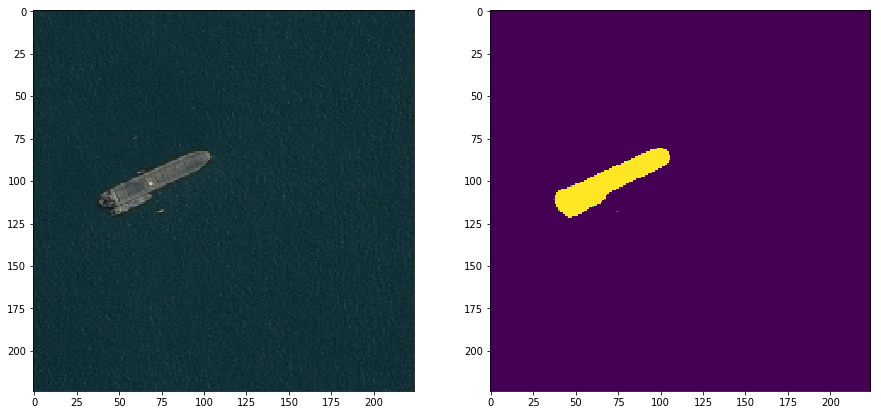

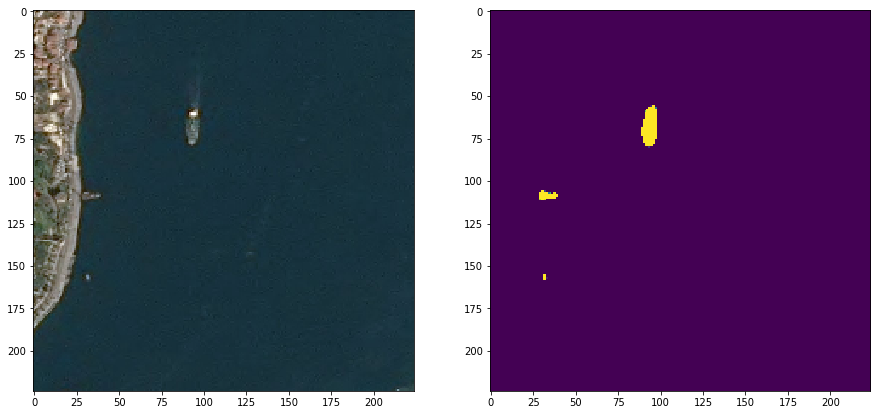

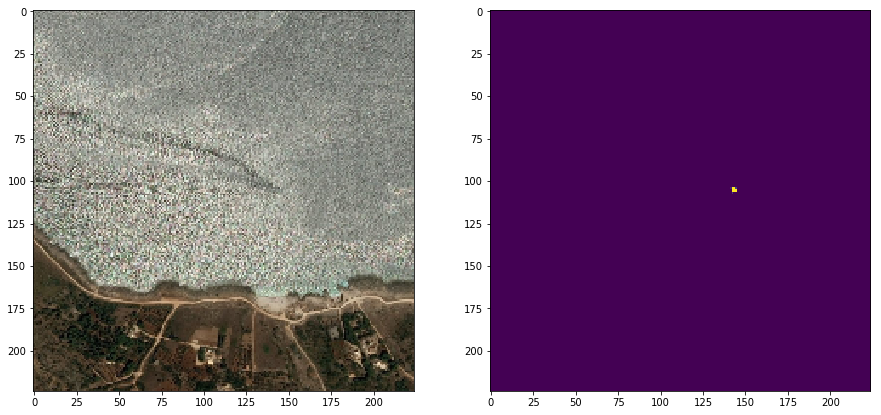

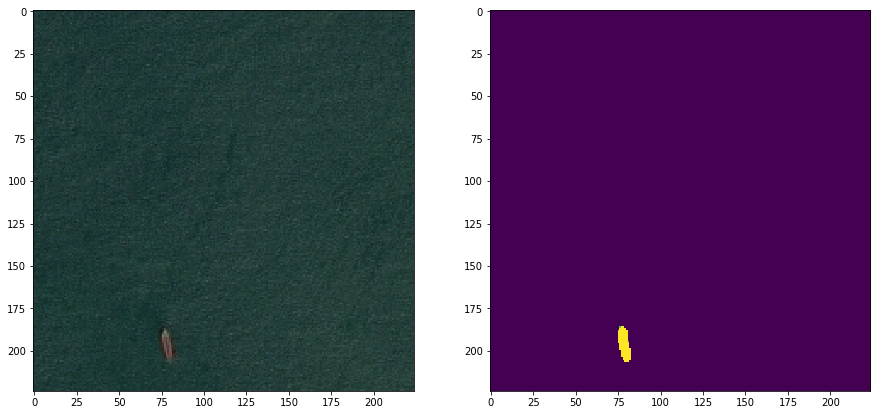

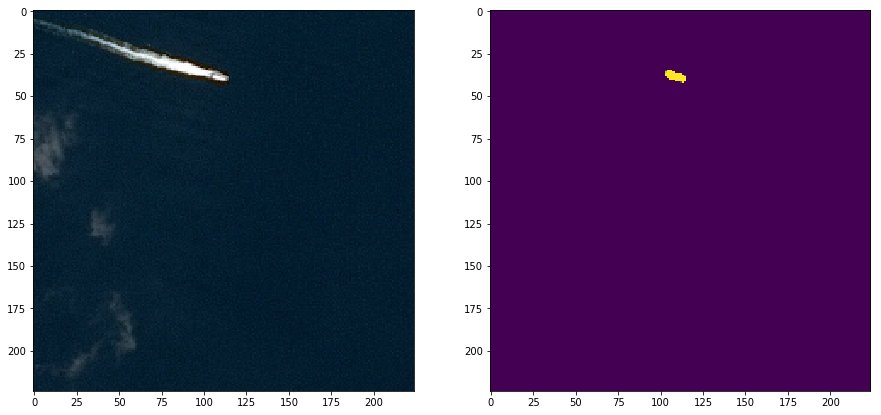

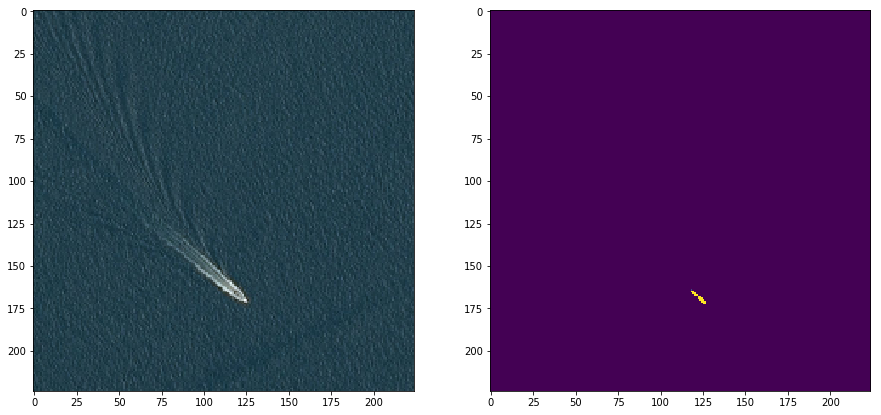

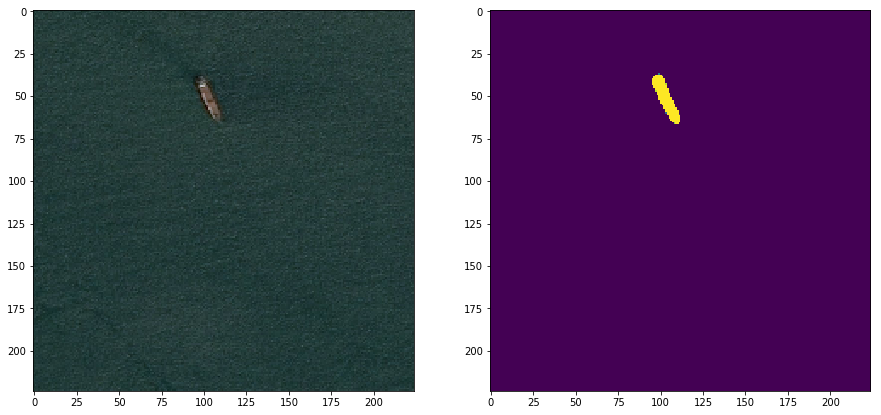

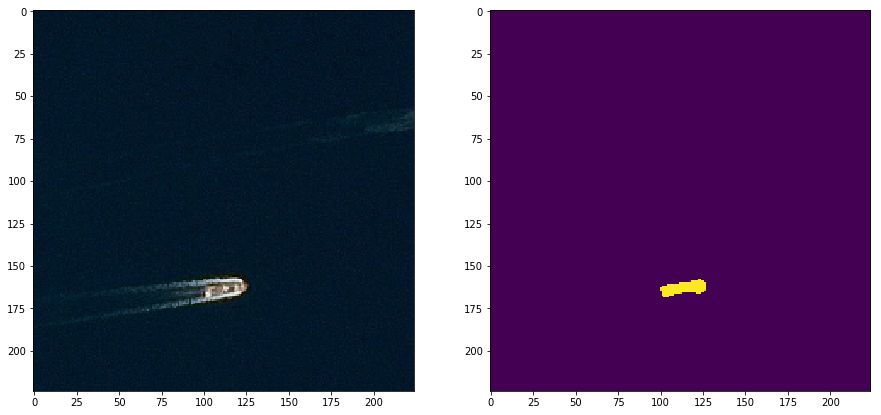

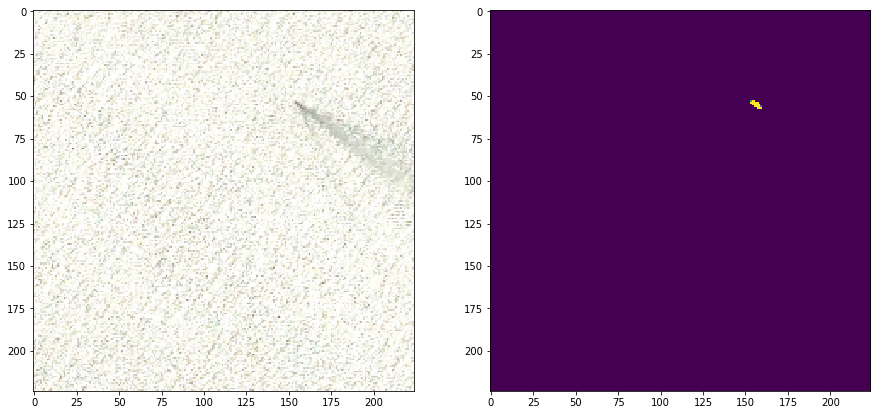

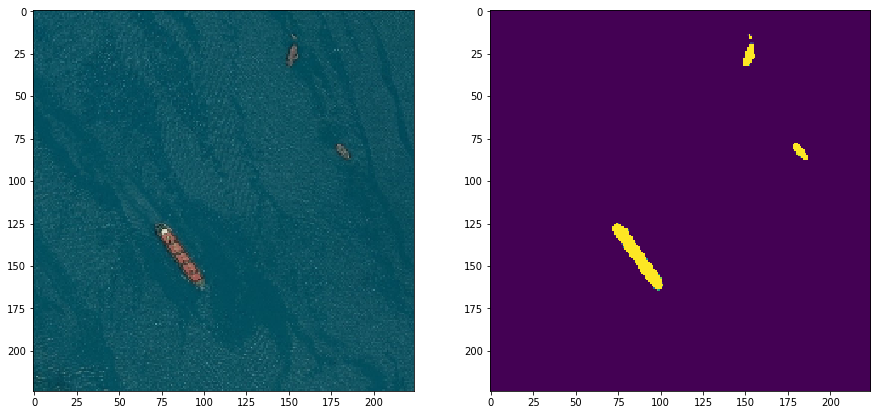

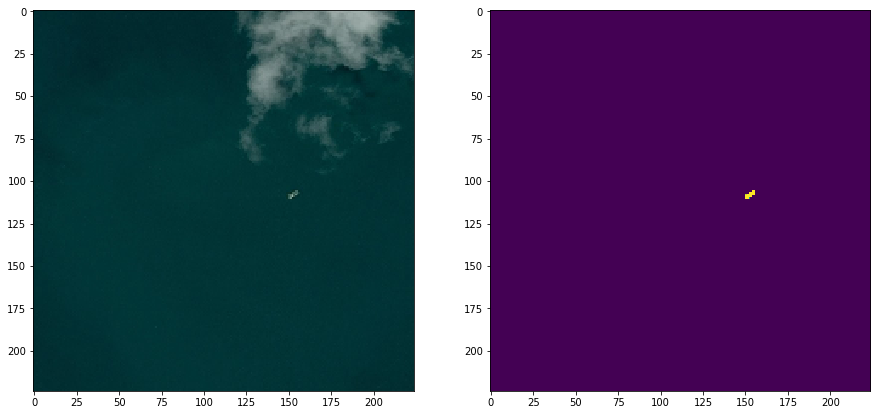

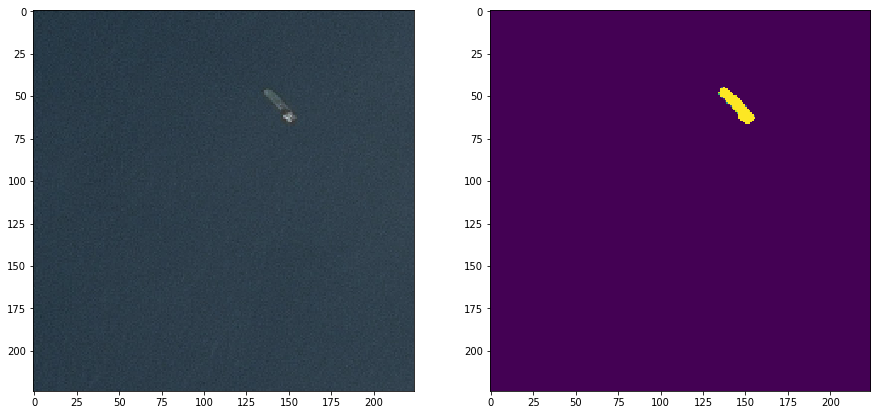

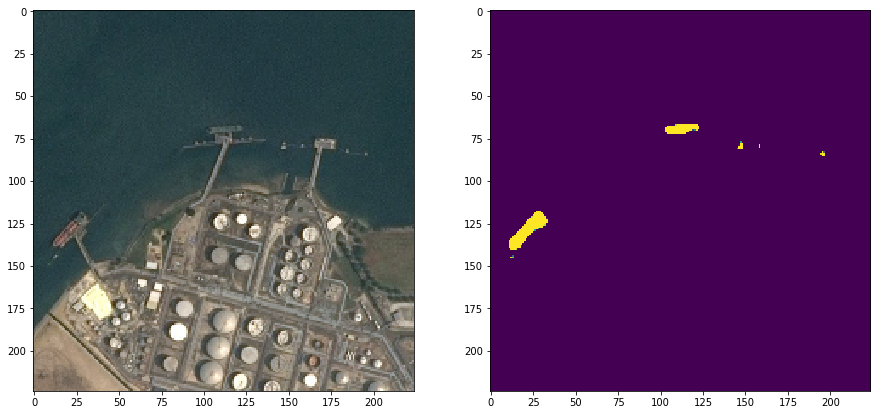

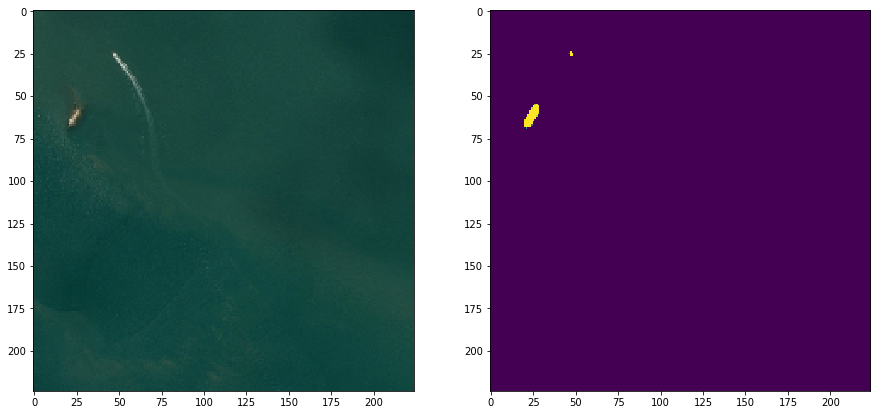

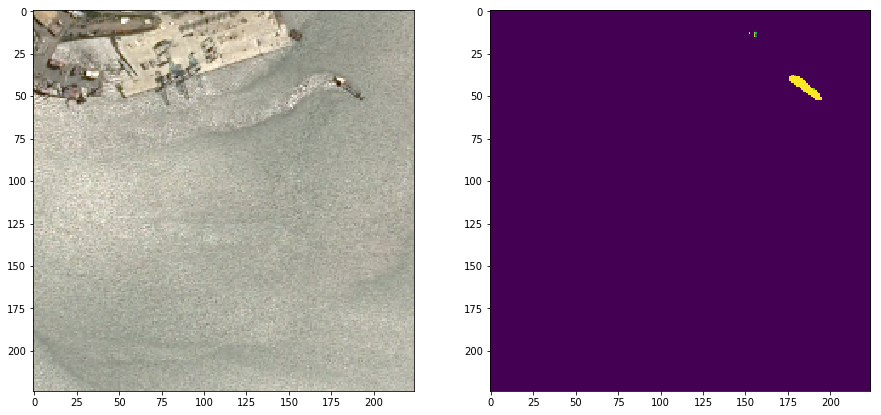

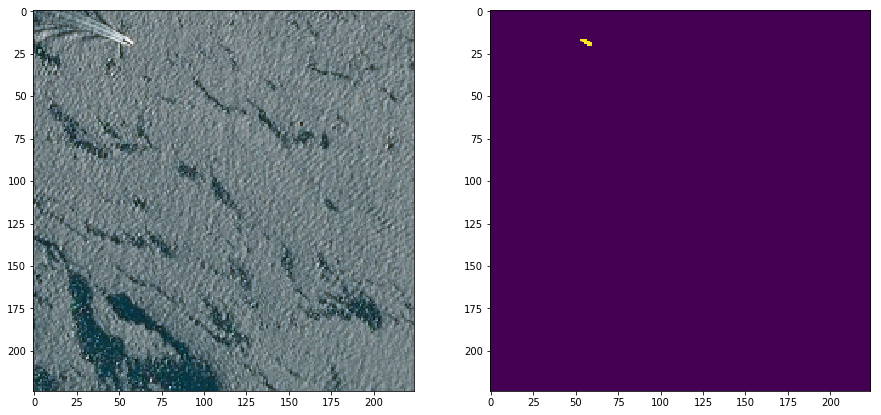

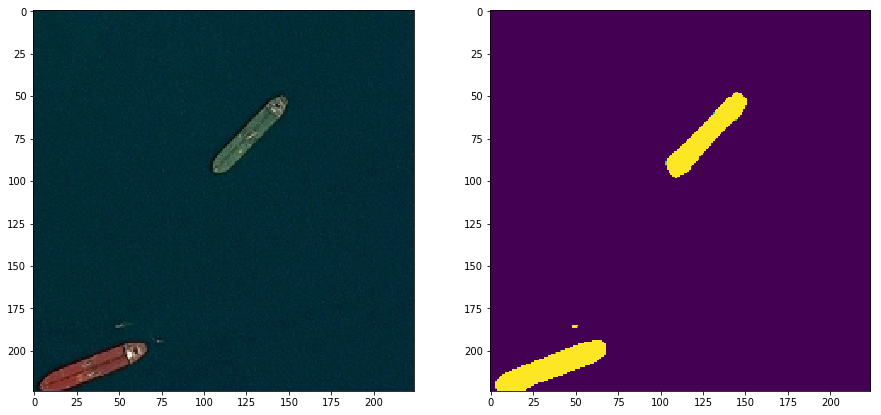

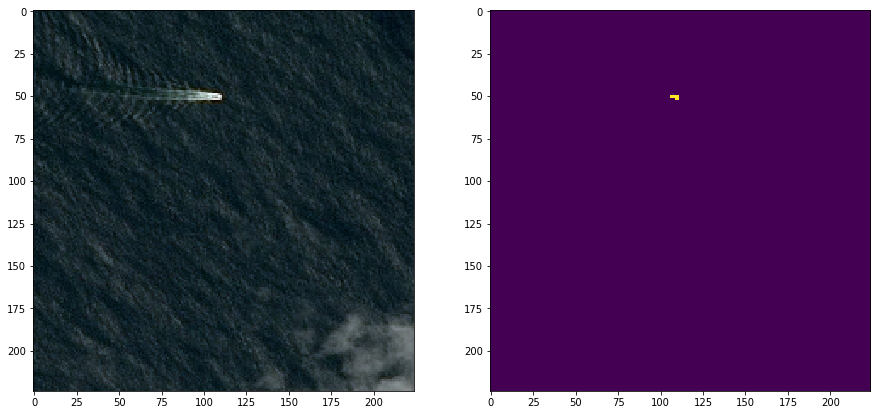

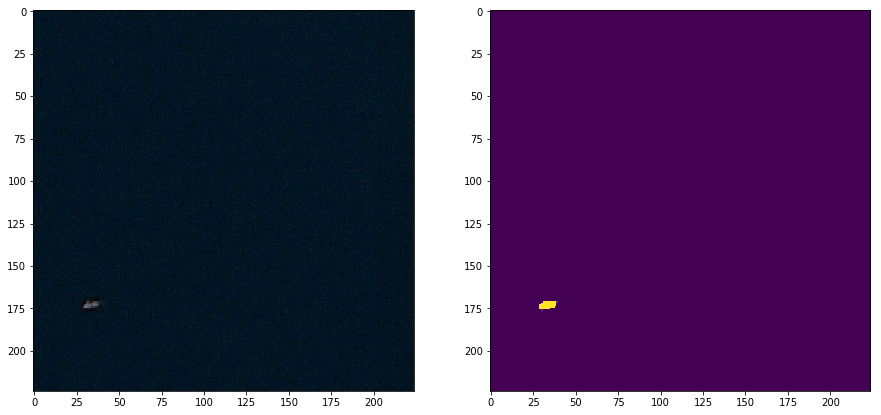

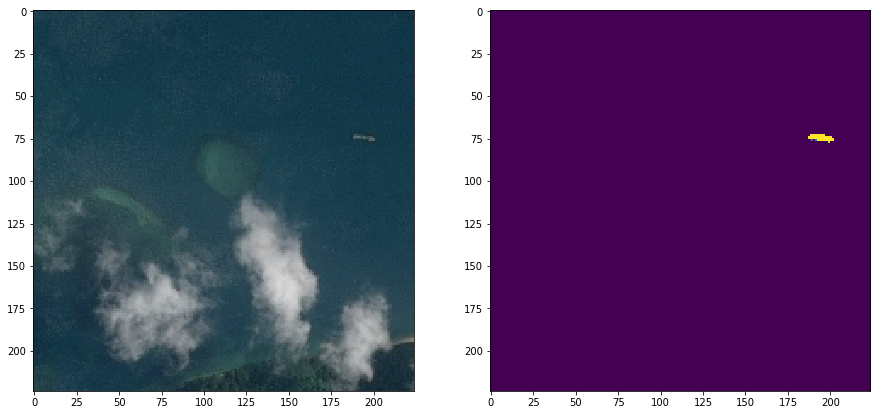

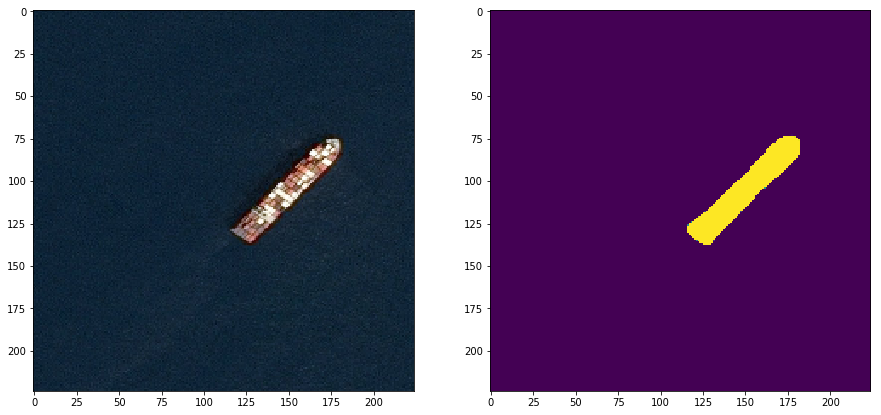

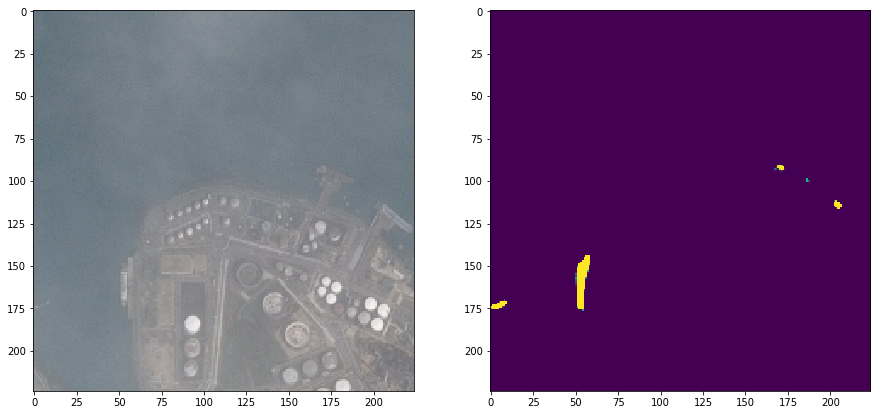

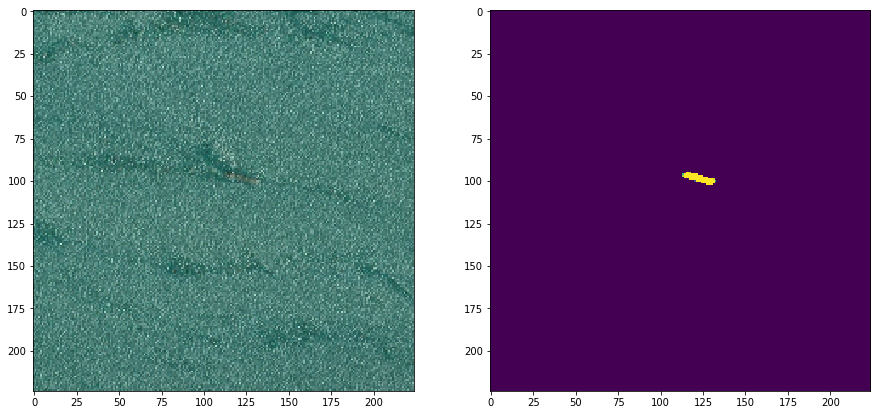

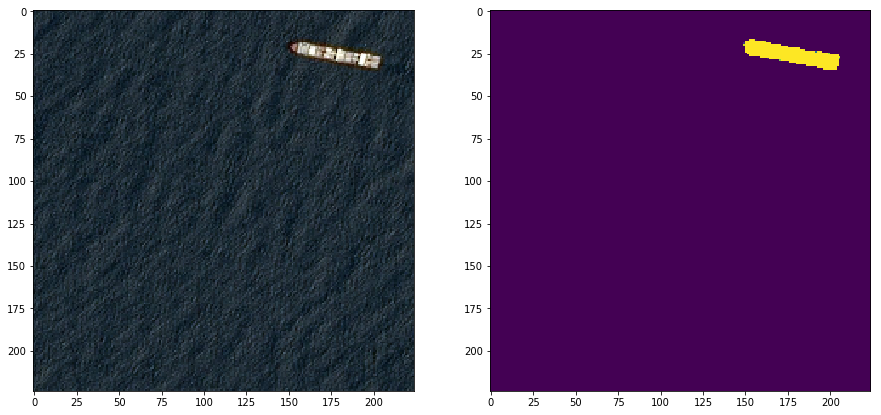

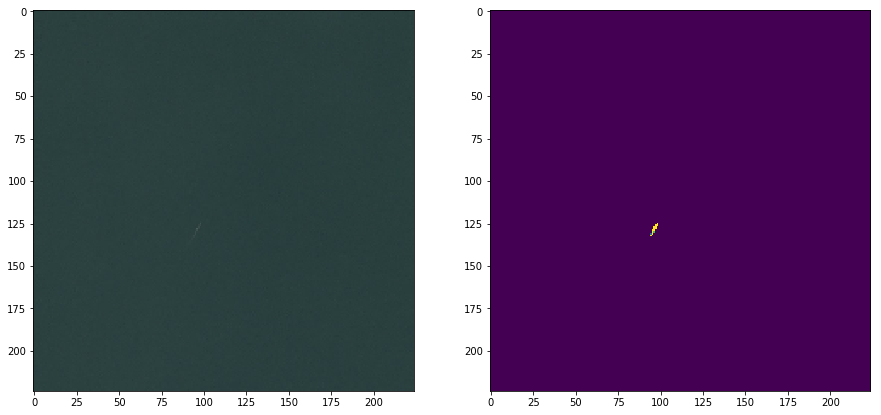

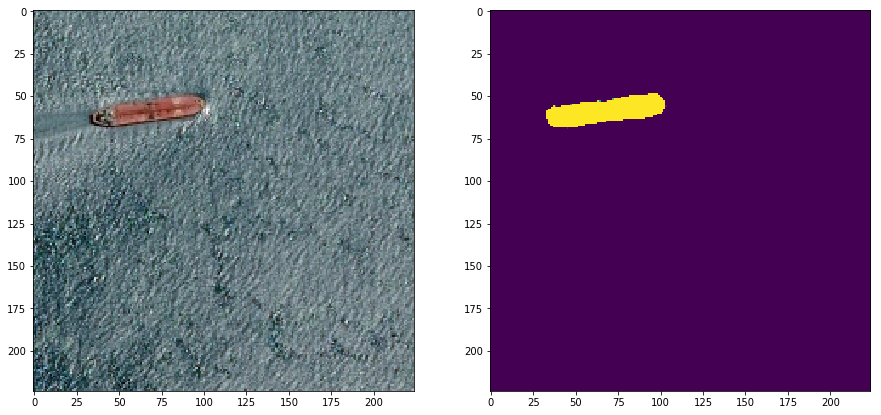

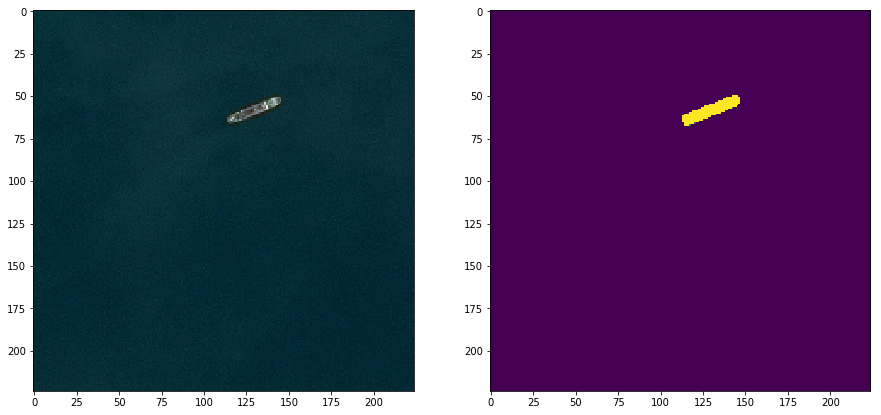

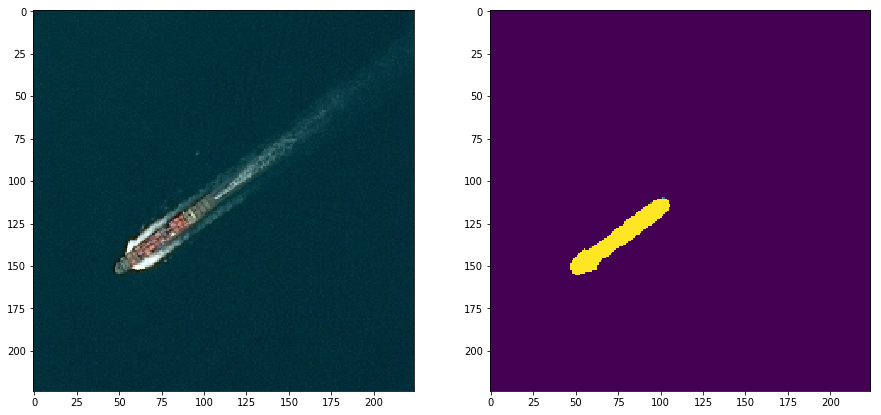

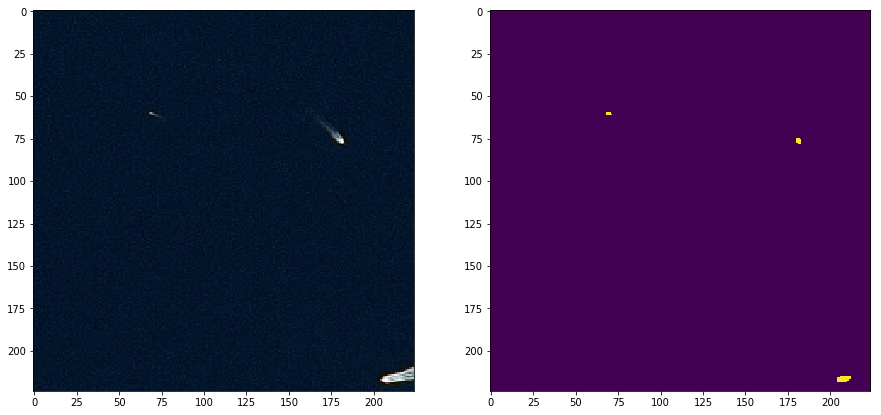

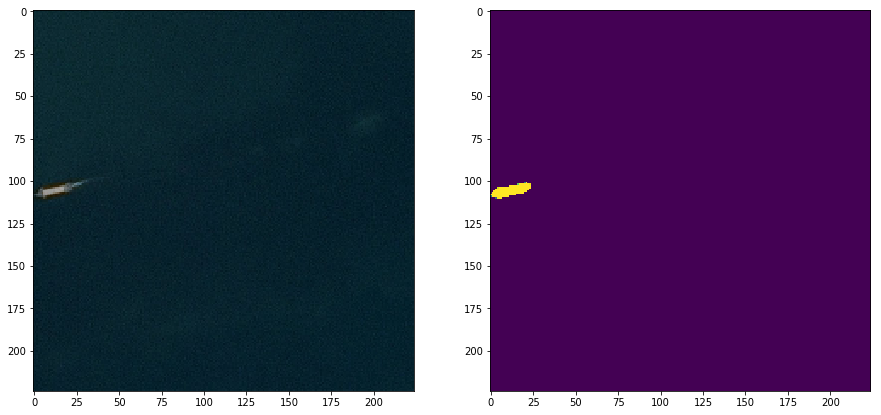

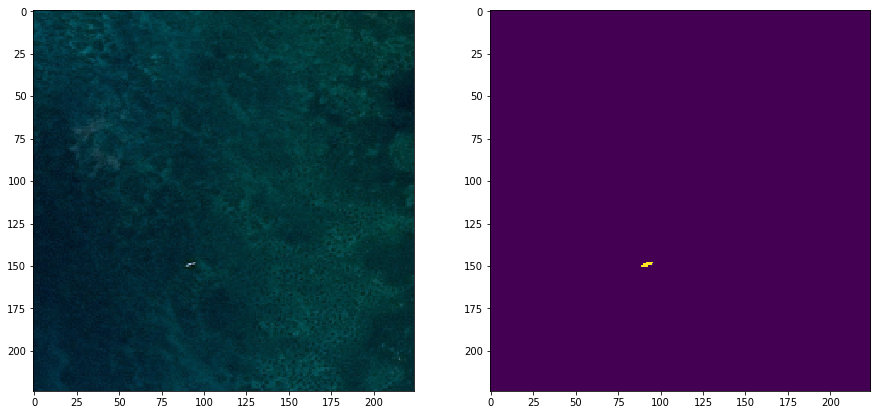

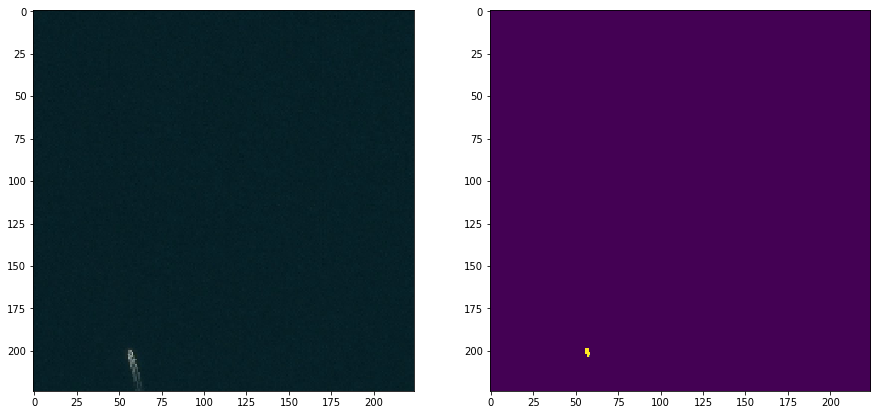

In [19]:
x_batch, y_batch = next(val_gen)
for i in range(0,32):
    image = x_batch[i]
    image = np.expand_dims(image, axis=0)
    mask = y_batch[i]
    prediction = model.predict(image)
    #print(prediction.shape)
    f,axarr = plt.subplots(1,2)
    f.set_figheight(15)
    f.set_figwidth(15)
    axarr[0].imshow(image[0,:,:,:])
    #axarr[1].imshow(mask[:, :, 0])
    axarr[1].imshow(prediction[0,:, :, 0])
    #plt.imshow(image)
    #plt.imshow(mask[:, :, 0])
    plt.show()
